In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm, lognorm, expon

In [2]:
font = {#'family' : 'normal',
         'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [3]:
theta = np.array([1])

In [152]:
def reward(theta, action):
    return np.cos(action)

In [173]:
n_shifts = 6
shift = np.arange(5)*np.pi/4

In [159]:
def ips(pi, pi0, pi0_samples, pi0_rewards):
    n = len(pi0_samples)
    ips_weights = pi.pdf(pi0_samples) / pi0.pdf(pi0_samples)
#     print('ips max', max(ips_weights))
    weighted_rewards = ips_weights * pi0_rewards
    return weighted_rewards.mean(), weighted_rewards.var(), ips_weights.mean()

def snips(pi, pi0, pi0_samples, pi0_rewards):
    n = len(pi0_samples)
    ips_weights = pi.pdf(pi0_samples) / pi0.pdf(pi0_samples)
#     print('ips max', max(ips_weights))
    weighted_rewards = ips_weights * pi0_rewards
    avg = weighted_rewards.sum()/(ips_weights.sum()+1e-9)
    u_i = (-pi0_rewards - avg)**2 * ips_weights**2
    u = np.sum(u_i)
    v = np.sum(ips_weights)**2
    var = u/v
    return avg, var, ips_weights.mean()

def ips_clipped(pi, pi0, pi0_samples, pi0_rewards, clip=100):
    n = len(pi0_samples)
    if clip is None:  # bottou heuristic
        clip = sorted(pi.pdf(pi0_samples)/pi0.pdf(pi0_samples))[-5]
#         print('\t\t', clip)
    ips_clipped_weights = np.clip(pi.pdf(pi0_samples) / pi0.pdf(pi0_samples), 0, clip)
#     print('ips-M max', max(ips_clipped_weights))
    weighted_rewards = ips_clipped_weights * pi0_rewards
    return weighted_rewards.mean(), np.var(weighted_rewards), ips_clipped_weights.mean()

def ips_dr(pi, pi0, pi0_samples, pi0_rewards):
    n = len(pi0_samples)
    mean_reward = pi0_rewards.mean()
    ips_weights = pi.pdf(pi0_samples) / pi0.pdf(pi0_samples)
    weighted_rewards = ips_weights * ((pi0_rewards - mean_reward) + mean_reward)
    return weighted_rewards.mean(), ips_weights.var(), ips_weights.mean()

    
def ips_ix(pi, pi0, pi0_samples, pi0_rewards):    
    n = len(pi0_samples)
    ips_ix_weights = pi.pdf(pi0_samples) / (pi0.pdf(pi0_samples) + pi.pdf(pi0_samples)/n)
    ips_ix_mean = (ips_ix_weights * pi0_rewards).mean()
    ips_ix_psi = (ips_ix_weights - 1) * pi0_rewards
    ips_ix_var = np.sqrt(np.sum((ips_ix_psi - ips_ix_psi.mean())**2) / (n-1))
    return ips_ix_mean, ips_ix_var, ips_ix_weights.mean()

In [183]:
np.random.seed(42)

methods = (ips, ips_clipped, snips, ips_ix,)

n = 10**5
runs = 30

mu0 = 0
sig0 = 1
pi0 = norm(mu0, sig0)

biases = dict([(m.__name__, np.zeros((runs,len(shift)))) for m in methods])
stds = dict([(m.__name__, np.zeros((runs,len(shift)))) for m in methods])
diags = dict([(m.__name__, np.zeros((runs,len(shift)))) for m in methods])

for i in range(runs):
    print('.', end='')
    pi0_samples = pi0.rvs(size=n)
    pi0_rewards = reward(theta, pi0_samples)
#     print('******* Pi0 := %s ********' % mu0)

#     print('\tPi0 rewards: %.5f +/- %.5f -- true: %.5f' % (
#         pi0_rewards.mean(), pi0_rewards.std()/np.sqrt(n), reward(theta, mu0)
#     ))

    for j, s in enumerate(shift):
        pi = norm(mu0+s, sig0)
#         print('******* Pi := %s ********' % (m))

        pi_samples = pi.rvs(size=10**6)
        pi_rewards = reward(theta, pi_samples)
    #     print(
    #         '\tPi       rewards: %.5f +/- %.5f -- true Reward=%.5f' % (
    #             pi_rewards.mean(), 
    #             pi_rewards.std()/np.sqrt(n), 
    #             reward(theta, m)
    #         )
    #     )
        for method in methods:
            avg, var, diag = method(pi, pi0, pi0_samples, pi0_rewards)
            bias = np.abs(avg - pi_rewards.mean())
            biases[method.__name__][i,j] = bias**2
            diags[method.__name__][i,j] = diag
    #         print('\t%12s reward: %.5f +/- %.5f [%.5f] -- bias: %.5f var: %.5f' % (
    #             method.__name__, avg, std, diag, bias, var
    #         ))
            means = []
            for k in range(30):
                pi0_samples = pi0.rvs(size=n)
                pi0_rewards = reward(theta, pi0_samples)
                avg, _, _ = method(pi, pi0, pi0_samples, pi0_rewards)
                means += [avg]
            stds[method.__name__][i,j] = np.var(means)

for method in methods:
    biases[method.__name__] = biases[method.__name__].mean(axis=0)
    stds[method.__name__] = stds[method.__name__].mean(axis=0)
    diags[method.__name__] = diags[method.__name__].mean(axis=0)

..............................

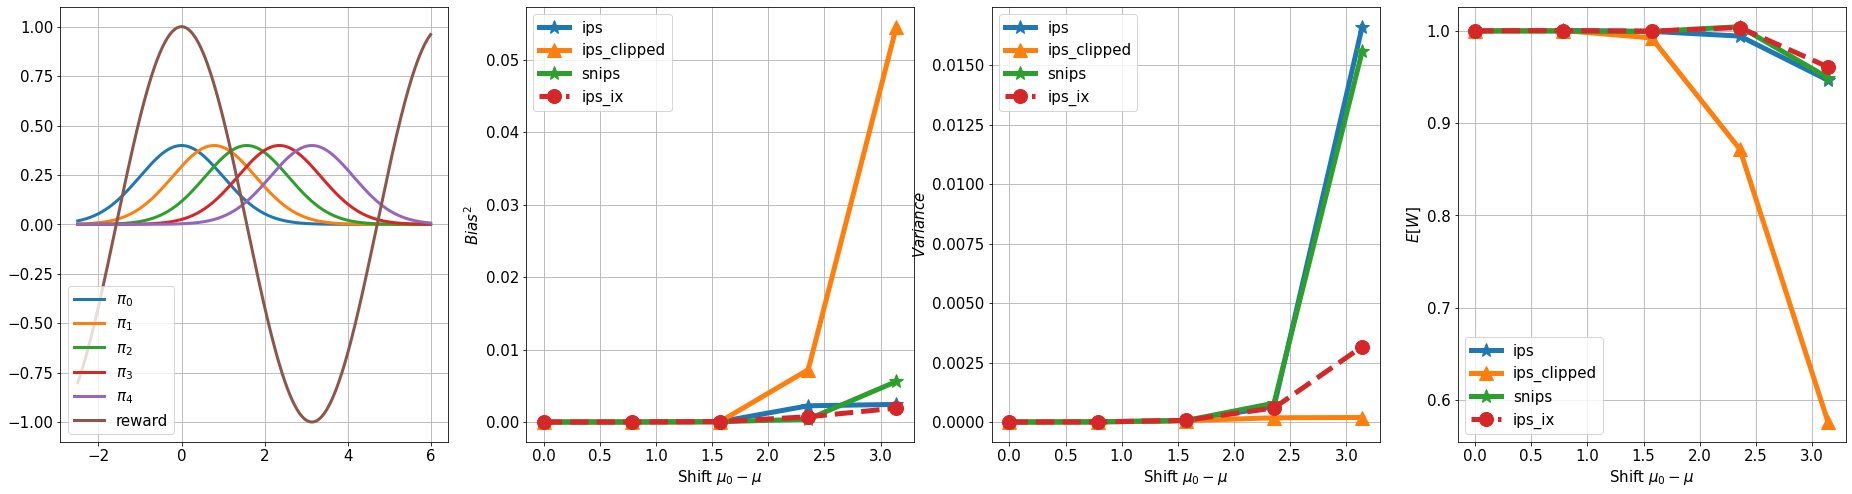

In [199]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(32,8))

x = np.linspace(-2.5,6,1000)
for i, s in enumerate(shift):
    pi = norm(mu0+s, sig0)
    ax0.plot(x, pi.pdf(x), label='$\pi_{%d}$' % i, lw=3)
ax0.plot(x, reward(theta, x), label='reward', lw=3)
#plt.yscale('symlog')
ax0.legend(loc='lower left')
ax0.grid()

# --


for m in biases.keys():
    style='*-'
    alpha=1
    if 'clip' in m:
        style = '^-'
    elif 'ix' in m:
        style = 'o--'
    ax1.plot(shift, biases[m], style, label=m, alpha=alpha, lw=5, ms=14)
#     ax1.fill_between(shift, biases[m]-np.sqrt(variances[m]), biases[m]+np.sqrt(variances[m]), 
#                      alpha=.25)
    ax2.plot(shift, stds[m], style, label=m, alpha=alpha, lw=5, ms=14)
    ax3.plot(shift, diags[m], style, label=m, alpha=alpha, lw=5, ms=14)

ax1.grid()
ax1.legend(loc='best')
ax1.set_ylabel('$Bias^2$')
ax1.set_xlabel('Shift $\mu_0-\mu$')
# ax1.set_yscale('log')
# ax1.set_xscale('log')

ax2.grid()
ax2.legend(loc='best')
ax2.set_ylabel('$Variance$')
ax2.set_xlabel('Shift $\mu_0-\mu$')
# ax2.set_yscale('log')
# ax2.set_xscale('log')

ax3.grid()
ax3.legend(loc='best')
ax3.set_ylabel('$E[W]$')
ax3.set_xlabel('Shift $\mu_0-\mu$')
#ax3.set_yscale('symlog')
# ax3.set_xscale('log')

plt.savefig('compare_estimators.png')